In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
# Initializing the constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 100

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/cotton-plant-disease/Cotton leaves/40 Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4788 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
print(class_names)

['Aphids', 'Army worm', 'Bacterial blight', 'Healthy', 'Powdery mildew', 'Target spot']


In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 5 2 3 4 1 5 3 5 1 0 2 3 3 3 1 0 3 2 0 3 5 4 3 0 1 1 5 5 0 5 4]


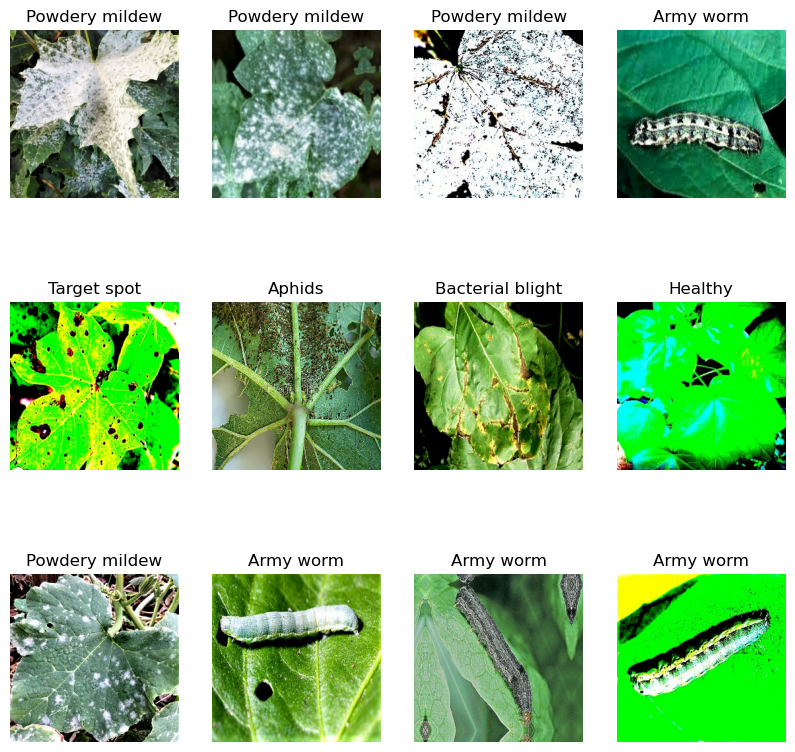

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

150

In [8]:
train_size = 0.8
len(dataset) * train_size

120.0

In [9]:
train_dataset = dataset.take(120)
len(train_dataset)

120

In [10]:
test_dataset = dataset.skip(120)
len(test_dataset)

30

In [11]:
val_size = 0.1
len(dataset) * val_size

15.0

In [12]:
val_dataset = test_dataset.take(15)
len(val_dataset)

15

In [13]:
test_dataset = test_dataset.skip(15)
len(test_dataset)

15

In [14]:
def get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    dataset_size = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    
    train_ds = dataset.take(train_size)    
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_dataset, val_dataset, test_dataset

In [15]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(dataset)

In [16]:
len(train_dataset)

120

In [17]:
len(val_dataset)

15

In [18]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/100
120/120 [==============================] - 90s 465ms/step - loss: 1.5632 - accuracy: 0.3409 - val_loss: 1.4054 - val_accuracy: 0.4229
Epoch 2/100
120/120 [==============================] - 37s 312ms/step - loss: 1.1698 - accuracy: 0.5432 - val_loss: 1.1094 - val_accuracy: 0.5437
Epoch 3/100
120/120 [==============================] - 37s 307ms/step - loss: 0.9778 - accuracy: 0.6255 - val_loss: 0.9428 - val_accuracy: 0.6229
Epoch 4/100
120/120 [==============================] - 36s 300ms/step - loss: 0.8814 - accuracy: 0.6661 - val_loss: 0.7891 - val_accuracy: 0.6854
Epoch 5/100
120/120 [==============================] - 36s 303ms/step - loss: 0.7680 - accuracy: 0.7122 - val_loss: 0.7667 - val_accuracy: 0.6833
Epoch 6/100
120/120 [==============================] - 37s 307ms/step - loss: 0.6342 - accuracy: 0.7719 - val_loss: 0.6430 - val_accuracy: 0.7750
Epoch 7/100
120/120 [==============================] - 36s 299ms/step - loss: 0.5615 - accuracy: 0.8000 - val_loss: 0.5977 -

In [27]:
scores = model.evaluate(test_dataset)

15/15 [==============================] - 24s 33ms/step - loss: 0.1244 - accuracy: 0.9509


In [28]:
scores

[0.1243843361735344, 0.9508547186851501]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 100, 'steps': 120}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

55

In [34]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.5632489919662476,
 1.1697986125946045,
 0.9777606129646301,
 0.8814467191696167,
 0.7680464386940002]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

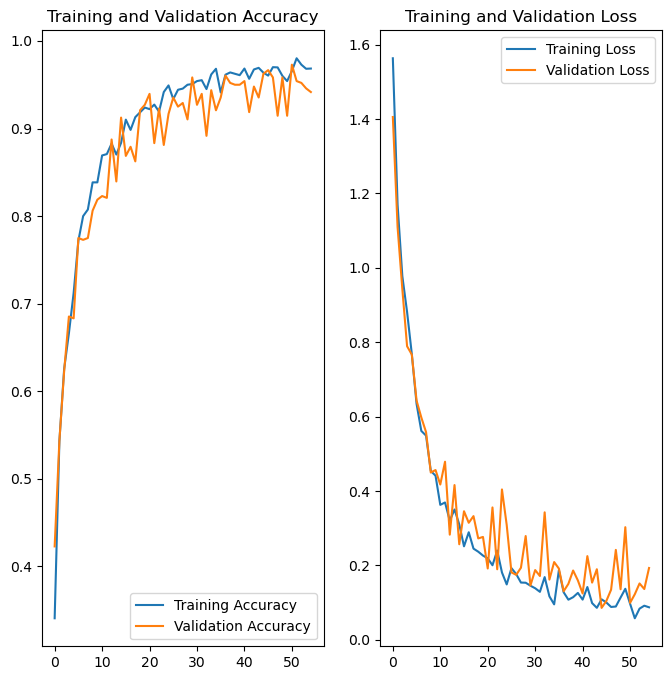

In [37]:
num_epochs = len(acc)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Aphids
1/1 [==============================] - 0s 149ms/step
predicted label: Aphids


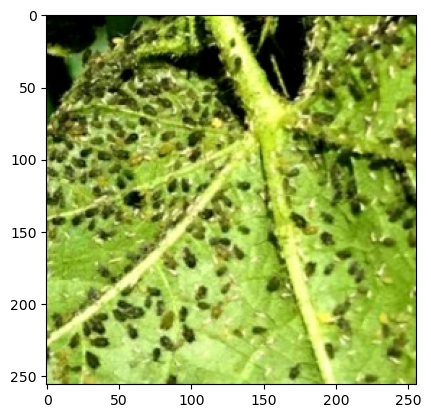

In [39]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


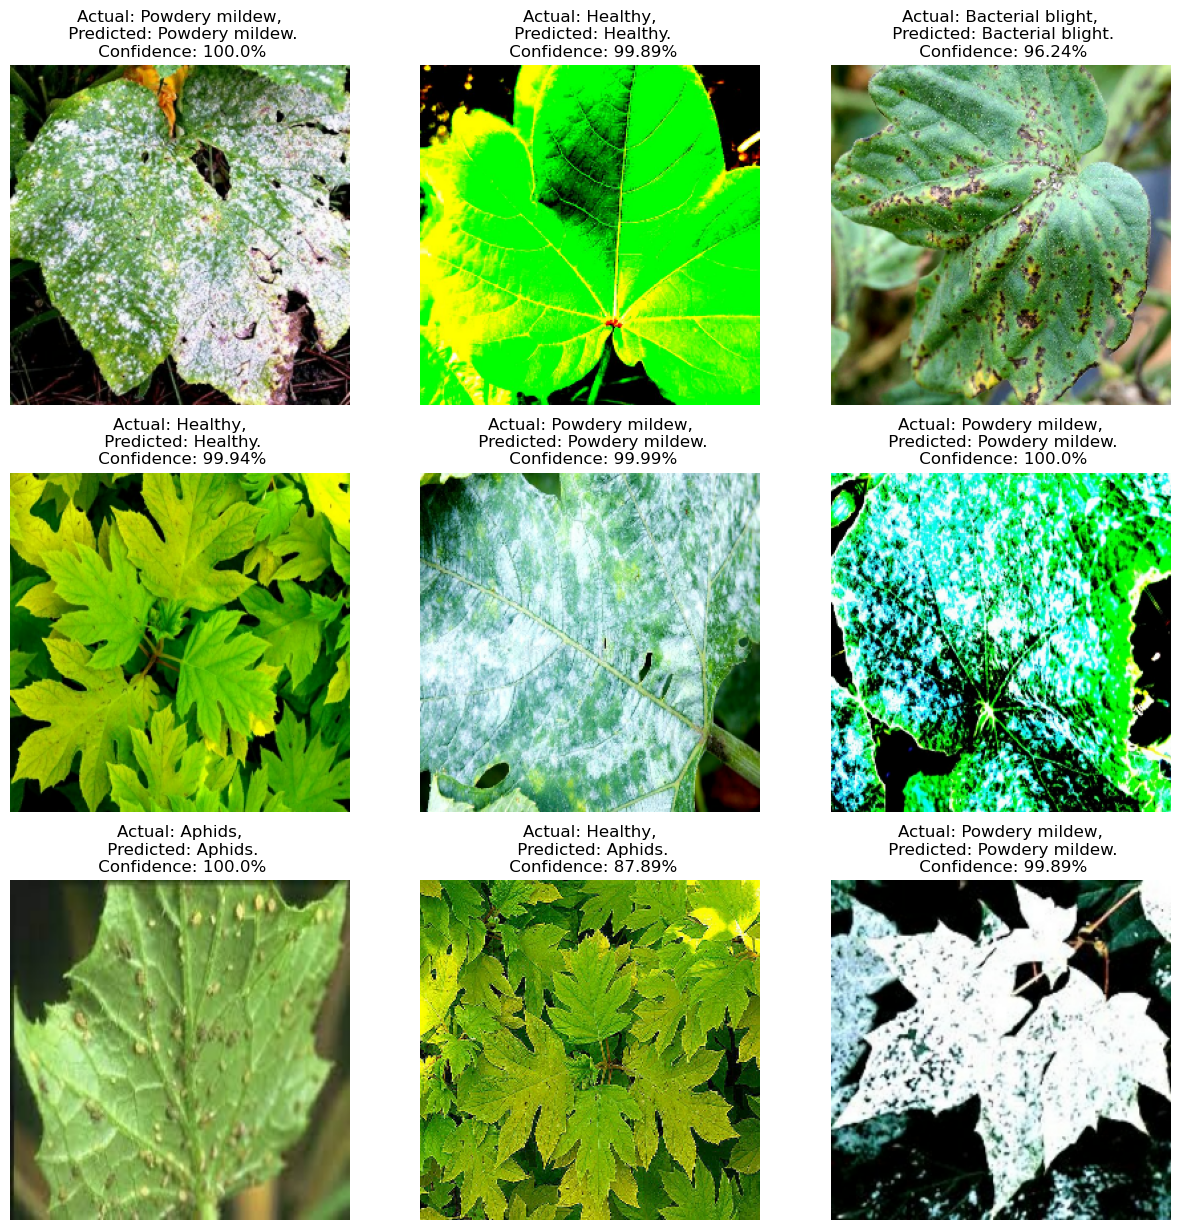

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [45]:
!conda update conda
!conda update --all

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/linux-64::imagemagick==7.1.0_62=pl5321h0dc3a92_0
  - conda-forge/noarch::networkx==2.7=pyhd8ed1ab_0
  - conda-forge/linux-64::cartopy==0.19.0.post1=py37h0c48da3_1
  - conda-forge/linux-64::pillow==9.2.0=py37h850a105_2
  - conda-forge/linux-64::openjpeg==2.5.0=h7d73246_1
  - conda-forge/noarch::seaborn==0.12.0=hd8ed1ab_0
  - file:///tmp/conda/linux-64::dlenv-base==1.0.20220913=py37hadde398_0
  - conda-forge/noarch::visions==0.7.4=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib==3.5.3=py37h89c1867_2
  - conda-forge/linux-64::phik==0.12.2=py37h237e563_0
  - file:///tmp/conda/linux-64::dlenv-tf-2-9-gpu==1.0.20220913=py37hddb555a_0
  - conda-forge/noarch::imagehash==4.3.0=pyhd8ed1ab_0
  - conda-forge/linux-64::matplotlib-base==

In [53]:
!mkdir Mymodel

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [54]:
import os
model_version=max([int(i) for i in os.listdir("/kaggle/working/Mymodel") + [0]])+1
model.save(f"/kaggle/working/Mymodel{model_version}")

In [55]:
from tensorflow.keras.models import load_model

In [56]:
model.save(os.path.join('/kaggle/working/','imageclassifier.h5'))